## Dependencies

In [1]:
import os
import glob
import torch
from torch.utils.data import ConcatDataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from src.utils import BrainTumorSegmentationDataset, BrainTumorSegmentationDataset2, plot_loss_curves
from pathlib import Path
from src.model1 import UNet
from src.model2 import UNetR2D
from src.model3 import MobileNetV3UNet
from src.train import train_UNet
from src.config.configuration import ConfigurationManager
import gc

## Global parameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
H,W = 256,256
torch.manual_seed(42)
batch_size = 16
lr = 1e-3
num_epochs = 500


dataset_path_1 = Path("./data/archive/")
dataset_path_2 = Path('./data/brain_mri/kaggle_3m/')
model_path_1 = Path('./models/model1/best_model2.pt')
model_path_2 = Path('./models/model2/best_model3.pt')
model_path_3 = Path('./models/model3/best_model3.pt')
log_path_1 = Path('./logs/train_log_unet_2.csv')
log_path_2 = Path('./logs/train_log_transunet_3.csv')
log_path_3 = Path('./logs/train_log_mobilenetv3_3.csv')

## Data loading

In [2]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor()
])

dataset_1 = BrainTumorSegmentationDataset(
    image_dir=os.path.join(dataset_path_1, "images"), 
    mask_dir=os.path.join(dataset_path_1, "masks"),
    transform=transform
)
dataset_2 = BrainTumorSegmentationDataset2(root_dir=dataset_path_2, transform=transform)

full_dataset = ConcatDataset(datasets=[dataset_1,dataset_2])

# Split dataset
train_size_1 = int(0.90 * len(full_dataset))
valid_size_1 = len(full_dataset) - train_size_1

train_dataset_1, valid_dataset_1 = random_split(full_dataset, [train_size_1, valid_size_1])

train_loader_1 = DataLoader(train_dataset_1,batch_size=batch_size,shuffle=True)
valid_loader_1 = DataLoader(valid_dataset_1,batch_size=batch_size,shuffle=True)

test_dataset = BrainTumorSegmentationDataset(
    image_dir= os.path.join(dataset_path_1,'test','images'),
    mask_dir=os.path.join(dataset_path_1,'test','masks'),
    transform=transform
)

test_loader_1 = DataLoader(test_dataset,batch_size=batch_size,shuffle=True)

## Training

### Model 1

In [ ]:
# model_1 = UNet()
# train_UNet(model=model_1,
#            train_loader=train_loader_1,
#            valid_loader=valid_loader_1,
#            device=device,
#            num_epochs=num_epochs,
#            lr=lr,
#            log_path=log_path_1,
#            model_path=model_path_1)

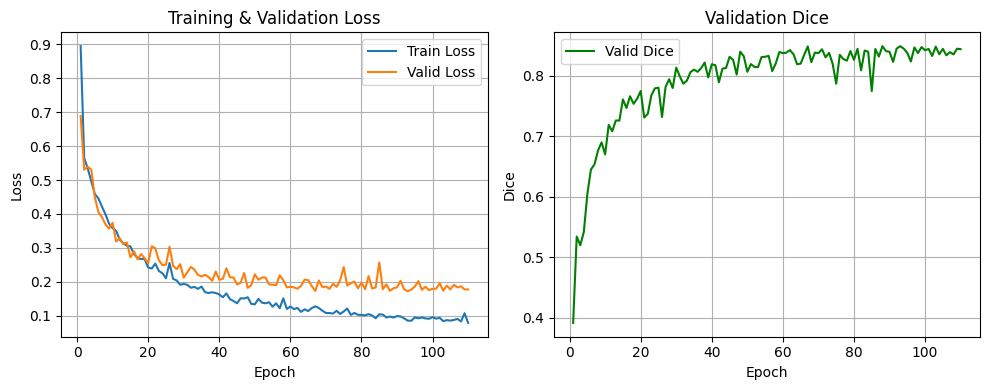

In [ ]:
# del model_1
torch.cuda.empty_cache()
gc.collect()

plot_loss_curves(log_path=log_path_1)

## Model 3

In [ ]:
model_3 = MobileNetV3UNet()
train_UNet(model=model_3,
           train_loader=train_loader_1,
           valid_loader=valid_loader_1,
           device=device,
           num_epochs=num_epochs,
           lr=lr,
           log_path=log_path_3,
           model_path=model_path_3)
del model_3
torch.cuda.empty_cache()
gc.collect()

plot_loss_curves(log_path=log_path_3)

### Model 2

In [ ]:
config_manager = ConfigurationManager()
model_params = config_manager.get_UNetR_params()
model_2 = UNetR2D(config=model_params)
train_UNet(model=model_2,
           train_loader=train_loader_1,
           valid_loader=valid_loader_1,
           device=device,
           num_epochs=num_epochs,
           lr=lr,
           log_path=log_path_2,
           model_path=model_path_2)
del model_2
torch.cuda.empty_cache()
gc.collect()

plot_loss_curves(log_path=log_path_2)